```{index} single: application; regression
```
```{index} pandas dataframe
```
```{index} single: solver; HiGHS
```

# Extra material: Wine quality prediction with $L_1$ regression

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description

Regression analysis aims to fit a predictive model to a dataset, and when executed successfully, this model can generate valuable forecasts for new data points. This notebook demonstrates how linear programming techniques coupled with Least Absolute Deviation (LAD) regression can construct a linear model to predict wine quality based on its physicochemical attributes. The example uses a well known data set from the machine learning community.

In [this 2009 article](https://doi.org/10.1016/j.dss.2009.05.016) by Cortez et al. comprehensive set of physical, chemical, and sensory quality metrics was gathered for an extensive range of red and white wines produced in Portugal. This dataset was subsequently contributed to the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). 

The next code cell downloads the red wine data directly from this repository.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

wines = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    sep=";",
)
display(wines)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Mean Absolute Deviation (MAD)

Given $n$ repeated observations of a response variable $y_i$ (in this case, the wine quality), the **mean absolute deviation** (MAD) of $y_i$ from the mean value $\bar{y}$ is

$$\text{MAD}\,(y) = \frac{1}{n} \sum_{i=1}^n | y_i - \bar{y}|$$


MAD = 0.68318


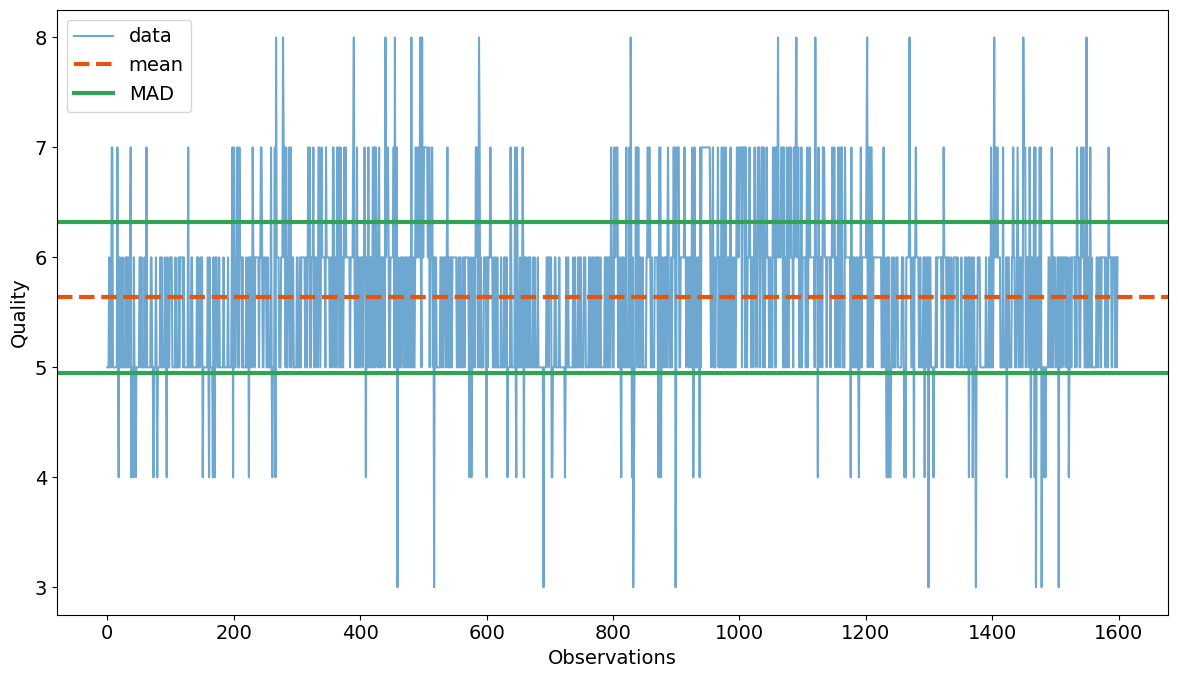

In [3]:
def MAD(df):
    return (df - df.mean()).abs().mean()


print(f'MAD = {MAD(wines["quality"]):.5f}')

plt.rcParams["font.size"] = 14
colors = plt.get_cmap("tab20c")
fig, ax = plt.subplots(figsize=(12, 7))
ax = wines["quality"].plot(alpha=0.7, color=colors(0.0))
ax.axhline(wines["quality"].mean(), color=colors(0.2), ls="--", lw=3)

mad = MAD(wines["quality"])
ax.axhline(wines["quality"].mean() + mad, color=colors(0.4), lw=3)
ax.axhline(wines["quality"].mean() - mad, color=colors(0.4), lw=3)
ax.legend(["data", "mean", "MAD"])
ax.set_xlabel("Observations")
ax.set_ylabel("Quality")
plt.tight_layout()
plt.show()

## A preliminary look at the data

The data consists of 1,599 measurements of eleven physical and chemical characteristics plus an integer measure of sensory quality recorded on a scale from 3 to 8. Histograms provides insight into the values and variability of the data set.

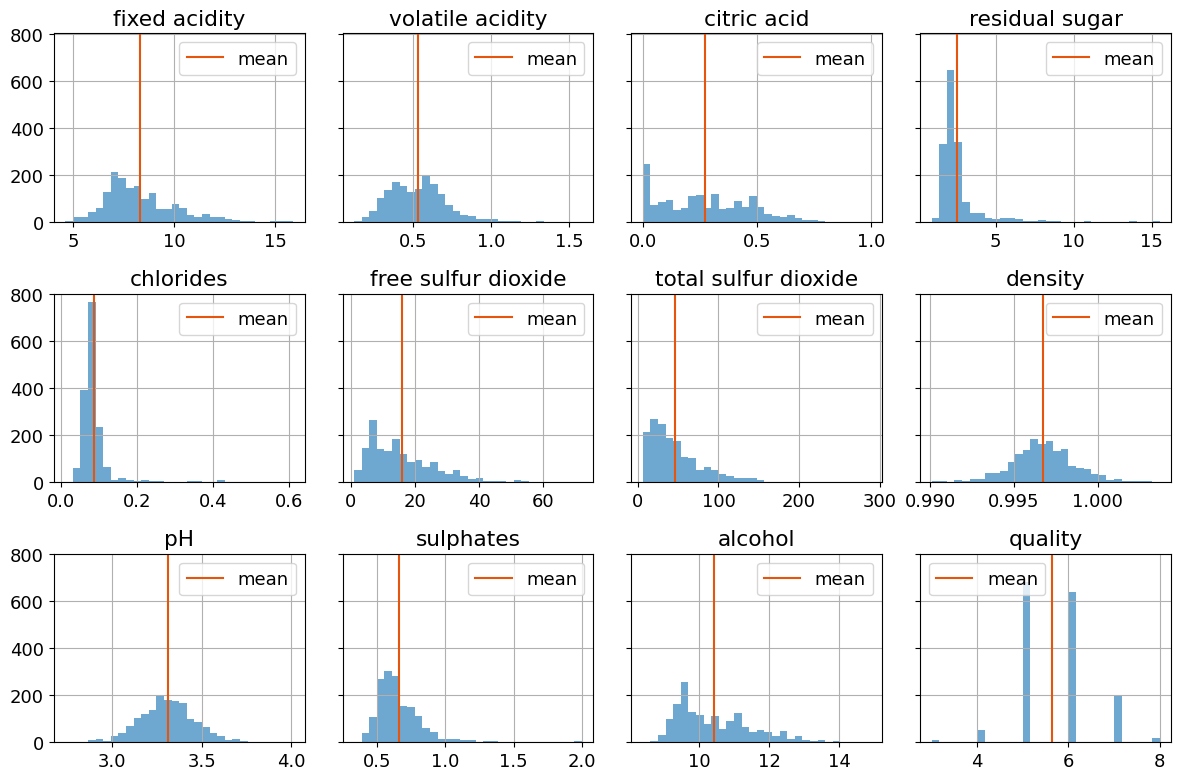

In [4]:
plt.rcParams["font.size"] = 13
colors = plt.get_cmap("tab20c")
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True)
for ax, column in zip(axes.flatten(), wines.columns):
    wines[column].hist(ax=ax, bins=30, color=colors(0.0), alpha=0.7)
    ax.axvline(wines[column].mean(), color=colors(0.2), label="mean")
    ax.set_title(column)
    ax.legend()

plt.tight_layout()

## Which features influence reported wine quality?

The art of regression is to identify the features that have explanatory value for a response of interest. This is where a person with deep knowledge of an application area, in this case an experienced onenologist will have a head start compared to the naive data scientist. In the absence of the experience, we proceed by examining the correlation among the variables in the data set.

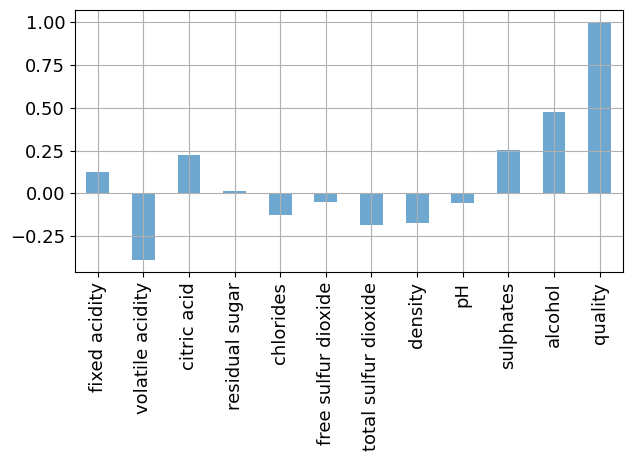

In [5]:
_ = wines.corr()["quality"].plot(kind="bar", grid=True, color=colors(0.0), alpha=0.7)
plt.tight_layout()

In [6]:
wines[["volatile acidity", "density", "alcohol", "quality"]].corr()

,volatile acidity,density,alcohol,quality
volatile acidity,1.000000,0.022026,-0.202288,-0.390558
density,0.022026,1.000000,-0.496180,-0.174919
alcohol,-0.202288,-0.496180,1.000000,0.476166
quality,-0.390558,-0.174919,0.476166,1.000000


Collectively, these figures suggest `alcohol` is a strong correlate of `quality`, and several additional factors as  candidates for explanatory variables..

## LAD line fitting to identify features

An alternative approach is perform a series of single feature LAD regressions to determine which features have the largest impact on reducing the mean absolute deviations in the residuals.

$$
\begin{align*}
\min \frac{1}{I} \sum_{i\in I} \left| y_i - a x_i - b \right|
\end{align*}
$$

This computation has been presented in a prior notebook.

In [7]:
def lad_fit_1(df, y_col, x_col):
    m = pyo.ConcreteModel("LAD Regression Model")

    N = len(df)
    m.I = pyo.RangeSet(N)

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i - 1, y_col]

    @m.Param(m.I)
    def X(m, i):
        return df.loc[i - 1, x_col]

    m.a, m.b = pyo.Var(), pyo.Var(domain=pyo.Reals)
    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)

    @m.Expression(m.I)
    def prediction(m, i):
        return m.a * m.X[i] + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m.y[i]

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I) / N

    return m


m = lad_fit_1(wines, "quality", "alcohol")
SOLVER.solve(m)
print(f"The mean absolute deviation for a single-feature regression is {m.MAD():0.5f}")

The mean absolute deviation for a single-feature regression is 0.54117


This calculation is performed for all variables to determine which variables are the best candidates to explain deviations in wine quality.

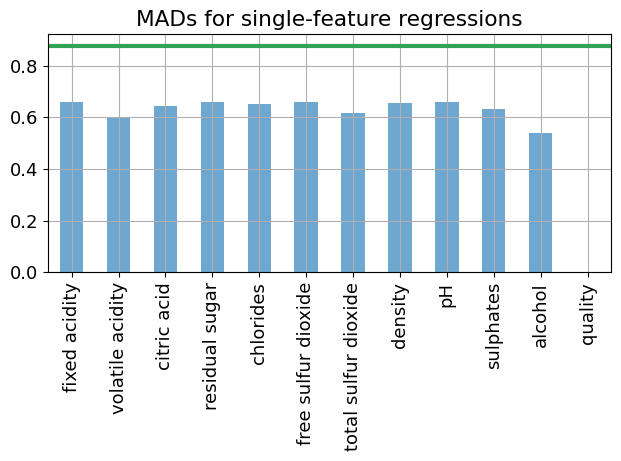

In [11]:
variables = {}
for i in wines.columns:
    m = lad_fit_1(wines, "quality", i)
    SOLVER.solve(m)
    variables[i] = m.MAD()

mad = (wines["alcohol"] - wines["alcohol"].mean()).abs().mean()
colors = plt.get_cmap("tab20c")
fig, ax = plt.subplots()
pd.Series(variables).plot(kind="bar", ax=ax, grid=True, alpha=0.7, color=colors(0.0))
ax.axhline(mad, color=colors(0.4), lw=3)
ax.set_title("MADs for single-feature regressions")
plt.tight_layout()
plt.show()

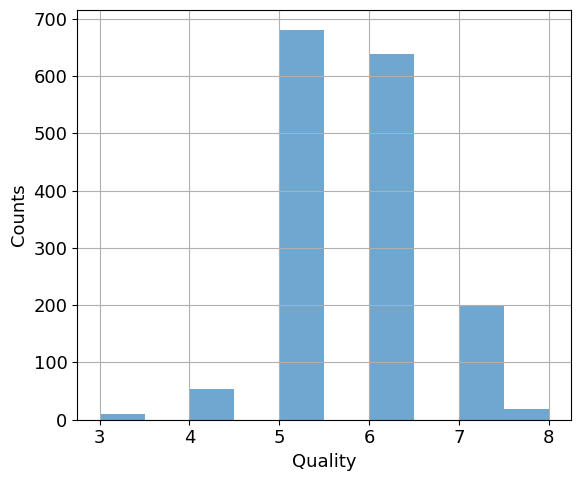

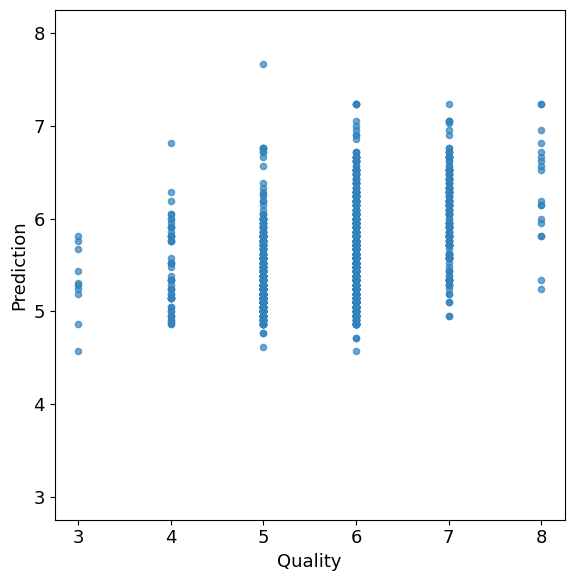

In [ ]:
wines["prediction"] = [m.prediction[i]() for i in m.I]

fig1, ax1 = plt.subplots(figsize=(6, 5))
wines["quality"].hist(label="data", alpha=0.7, color=plt.get_cmap("tab20c")(0))
ax1.set_xlabel("Quality")
ax1.set_ylabel("Counts")
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 6))
wines.plot(
    x="quality",
    y="prediction",
    kind="scatter",
    alpha=0.7,
    color=plt.get_cmap("tab20c")(0),
    ax=ax2,
)
ax2.set_xlabel("Quality")
ax2.set_ylabel("Prediction")
ax2.set_aspect("equal", "box")
min_val = min(ax2.get_xlim()[0], ax2.get_ylim()[0])
max_val = max(ax2.get_xlim()[1], ax2.get_ylim()[1])
ax2.set_xlim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
plt.tight_layout()
plt.show()

## Multivariate $L_1$-regression

Let us now perform a full multivariate $L_1$-regression on the wine dataset to predict the wine quality $y$ using the provided wine features. We aim to find the coefficients $m_j$'s and $b$ that minimize the mean absolute deviation (MAD) by solving the following problem:

$$
\begin{align*}
\text{MAD}\,(\hat{y}) = \min_{m, \, b} \quad & \frac{1}{n} \sum_{i=1}^n | y_i - \hat{y}_i| \\
\\
\text{s. t.}\quad & \hat{y}_i = \sum_{j=1}^J x_{i, j} m_j + b & \forall i = 1, \dots, n,
\end{align*}
$$

where $x_{i, j}$ are values of 'explanatory' variables, i.e., the 11 physical and chemical characteristics of the wines. By taking care of the absolute value appearing in the objective function, this can be implemented in Pyomo as a linear optimization problem as follows:

MAD = 0.49980

alcohol                 0.34242
volatile acidity       -0.98062
citric acid            -0.28928
sulphates               0.90609
total sulfur dioxide   -0.00219
density               -18.50083
fixed acidity           0.06382


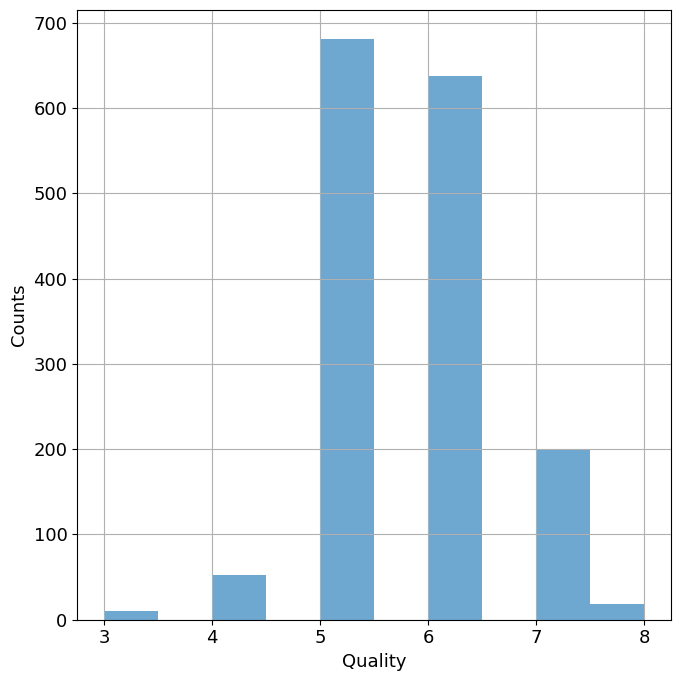

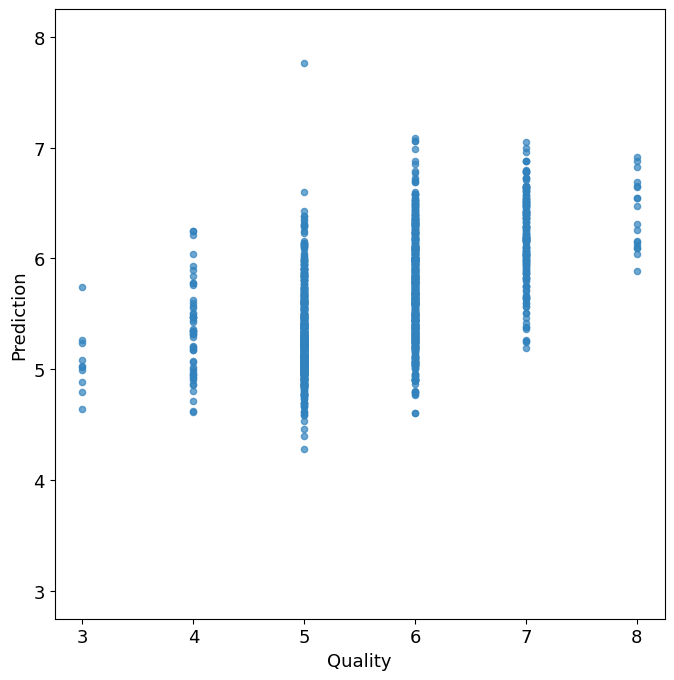

In [ ]:
def l1_fit(df, y_col, x_cols):
    m = pyo.ConcreteModel("L1 Regression Model")

    N = len(df)
    m.I = pyo.RangeSet(N)
    m.J = pyo.Set(initialize=x_cols)

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i - 1, y_col]

    @m.Param(m.I, m.J)
    def X(m, i, j):
        return df.loc[i - 1, j]

    m.a = pyo.Var(m.J)
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)

    @m.Expression(m.I)
    def prediction(m, i):
        return sum(m.a[j] * m.X[i, j] for j in m.J) + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m.y[i]

    @m.Objective(sense=pyo.minimize)
    def MAD(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I) / N

    return m


m = l1_fit(
    wines,
    "quality",
    [
        "alcohol",
        "volatile acidity",
        "citric acid",
        "sulphates",
        "total sulfur dioxide",
        "density",
        "fixed acidity",
    ],
)
SOLVER.solve(m)
print(f"MAD = {m.MAD():0.5f}\n")

for j in m.J:
    print(f"{j: <20}  {pyo.value(m.a[j]):9.5f}")

wines["prediction"] = [pyo.value(m.prediction[i]) for i in m.I]

fig1, ax1 = plt.subplots(figsize=(7, 7))
wines["quality"].hist(label="data", alpha=0.7, color=plt.get_cmap("tab20c")(0))
ax1.set_xlabel("Quality")
ax1.set_ylabel("Counts")
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(7, 7))
wines.plot(
    x="quality",
    y="prediction",
    kind="scatter",
    alpha=0.7,
    color=plt.get_cmap("tab20c")(0),
    ax=ax2,
)
ax2.set_xlabel("Quality")
ax2.set_ylabel("Prediction")
ax2.set_aspect("equal", "box")
min_val = min(ax2.get_xlim()[0], ax2.get_ylim()[0])
max_val = max(ax2.get_xlim()[1], ax2.get_ylim()[1])
ax2.set_xlim(min_val, max_val)
ax2.set_ylim(min_val, max_val)
plt.tight_layout()
plt.show()

## How do these models perform?

A successful regression model would demonstrate a substantial reduction from $\text{MAD}\,(y)$ to $\text{MAD}\,(\hat{y})$. The value of $\text{MAD}\,(y)$ sets a benchmark for the regression. The linear regression model clearly has some capability to explain the observed deviations in wine quality. Tabulating the results of the regression using the MAD statistic we find

<div align="center">

| Regressors | MAD |
| :--- | ---: |
| none | 0.683 |
| alcohol only | 0.541 | 
| all | 0.500 |

</div>

Are these models good enough to replace human judgment of wine quality? The reader can be the judge.